## In this notebook I have the done the following operations:

1. Merging the two provided datasets for predicting chances of deal_closing using Text transcripts from conversations between Sales agents and customers.

2. Doing basic EDA on the Text obtained. It has been neatly documented.
3. Building a Text Classifier using numeric features as well using a Naive Bayes Model using Hyperparameter tuning and different vectorizers( BOW and TFIDF )

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sales = pd.read_excel('sales-pipeline.xlsx')
interactions=pd.read_excel('interactions.xlsx')

In [4]:
train = sales[sales['Deal_Stage'] != 'In Progress']
train.head()

,Account,Opportunity_ID,Sales_Agent,SalesAgentEmailID,ContactEmailID,Deal_Stage,Product,Close_Value,Created Date,Close Date,DateDiff
0,Konex,3KR50X38,Corliss Cosme,corliss@piedpiper.com,delila@konex.com,Won,GTX Plus Basic,1255,2016-01-04,2016-05-24,141
1,Finjob,YFS5KLJJ,Rosalina Dieter,rosalina@piedpiper.com,belinda@finjob.com,Won,MG Special,45,2016-01-04,2016-11-02,303
2,Kinnamplus,N0ONCYVZ,Donn Cantrell,donn@piedpiper.com,monte@kinnamplus.com,Lost,MG Special,1054,2016-01-06,2016-12-07,336
4,Initech,G8AO5FA2,Wilburn Farren,wilburn@piedpiper.com,alejandro@initech.com,Lost,MG Advanced,517,2016-01-06,2016-09-18,256
5,Stanredtax,2V848WZD,Lajuana Vencill,lajuana@piedpiper.com,candice@stanredtax.com,Won,MG Advanced,3180,2016-01-07,2016-01-31,24


In [6]:
print(min(train['Created Date']))
print(max(train['Close Date']))

2016-01-04 00:00:00
2019-12-31 00:00:00


In [7]:
import datetime
start = datetime.datetime(year=2016, 
    month=1,
    day=4)

end = datetime.datetime(year=2019, 
    month=12,
    day=31)

print(start, end)

2016-01-04 00:00:00 2019-12-31 00:00:00


In [8]:
df = interactions[(interactions['InteractionDate'] >= start) & (interactions['InteractionDate'] <= end)]

In [9]:
df.shape

(316776, 6)

In [10]:
train.shape

(6711, 11)

In [11]:
interactions.shape

(316776, 6)

In [12]:
newdf = pd.merge(train, df, how='left', left_on=['SalesAgentEmailID','ContactEmailID'], right_on = ['fromEmailId','toEmailId'])

In [13]:
newdf.shape

(704096, 17)

In [14]:
newdf.isnull().sum()

Account                            0
Opportunity_ID                     0
Sales_Agent                        0
SalesAgentEmailID                  0
ContactEmailID                     0
Deal_Stage                         0
Product                            0
Close_Value                        0
Created Date                       0
Close Date                         0
DateDiff                           0
interactionID                      0
fromEmailId                        0
toEmailId                          0
InteractionDate                    0
InteractionType(Call/Email/SMS)    0
Extracted Interaction Text         0
dtype: int64

In [15]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 704096 entries, 0 to 704095
Data columns (total 17 columns):
Account                            704096 non-null object
Opportunity_ID                     704096 non-null object
Sales_Agent                        704096 non-null object
SalesAgentEmailID                  704096 non-null object
ContactEmailID                     704096 non-null object
Deal_Stage                         704096 non-null object
Product                            704096 non-null object
Close_Value                        704096 non-null int64
Created Date                       704096 non-null datetime64[ns]
Close Date                         704096 non-null datetime64[ns]
DateDiff                           704096 non-null int64
interactionID                      704096 non-null int64
fromEmailId                        704096 non-null object
toEmailId                          704096 non-null object
InteractionDate                    704096 non-null datetime64[ns

In [16]:
newdf.columns

Index(['Account', 'Opportunity_ID', 'Sales_Agent', 'SalesAgentEmailID',
       'ContactEmailID', 'Deal_Stage', 'Product', 'Close_Value',
       'Created Date', 'Close Date', 'DateDiff', 'interactionID',
       'fromEmailId', 'toEmailId', 'InteractionDate',
       'InteractionType(Call/Email/SMS)', 'Extracted Interaction Text'],
      dtype='object')

In [17]:
cols_to_use = ['Sales_Agent', 'Deal_Stage', 'Product', 'Close_Value','DateDiff','Extracted Interaction Text']
newdf = newdf[cols_to_use]

In [18]:
newdf.head()

,Sales_Agent,Deal_Stage,Product,Close_Value,DateDiff,Extracted Interaction Text
0,Corliss Cosme,Won,GTX Plus Basic,1255,141,We are writing from GHF regarding the previous...
1,Corliss Cosme,Won,GTX Plus Basic,1255,141,I had asked you to send the progress on the pr...
2,Corliss Cosme,Won,GTX Plus Basic,1255,141,"I wish to commend your receptionist, Jany Dan,..."
3,Corliss Cosme,Won,GTX Plus Basic,1255,141,I need to cancel the appointment I made to you...
4,Corliss Cosme,Won,GTX Plus Basic,1255,141,Congratulations! Your hard work has paid off! ...


In [19]:
newdf['Deal_Stage'].value_counts()

Won     443478
Lost    260618
Name: Deal_Stage, dtype: int64

In [20]:
newdf['Deal_Stage'] = newdf['Deal_Stage'].map({'Won':1,'Lost':0})

In [21]:
newdf.groupby('Sales_Agent')['Deal_Stage'].mean().sort_values()

Sales_Agent
Lajuana Vencill       0.557664
Markita Hansen        0.562160
Gladys Colclough      0.572299
Donn Cantrell         0.573070
Niesha Huffines       0.609764
Daniell Hammack       0.611736
Elease Gluck          0.612250
Anna Snelling         0.615083
Kary Hendrixson       0.621899
Cassey Cress          0.623001
Marty Freudenburg     0.625266
Zane Levy             0.627858
Corliss Cosme         0.629671
Darcel Schlecht       0.631217
Violet Mclelland      0.637473
Vicki Laflamme        0.637723
Kami Bicknell         0.637953
James Ascencio        0.643653
Rosie Papadopoulos    0.650612
Jonathan Berthelot    0.655010
Moses Frase           0.655804
Garret Kinder         0.659641
Boris Faz             0.663723
Cecily Lampkin        0.666389
Versie Hillebrand     0.666527
Reed Clapper          0.669551
Rosalina Dieter       0.671260
Maureen Marcano       0.683421
Wilburn Farren        0.712372
Hayden Neloms         0.717285
Name: Deal_Stage, dtype: float64

In [22]:
ordered_agents = newdf.groupby('Sales_Agent')['Deal_Stage'].mean().sort_values().index

In [23]:
ordinal_agents = {k:i for i, k in enumerate(ordered_agents, 0)} 
ordinal_agents

{'Lajuana Vencill': 0,
 'Markita Hansen': 1,
 'Gladys Colclough': 2,
 'Donn Cantrell': 3,
 'Niesha Huffines': 4,
 'Daniell Hammack': 5,
 'Elease Gluck': 6,
 'Anna Snelling': 7,
 'Kary Hendrixson': 8,
 'Cassey Cress': 9,
 'Marty Freudenburg': 10,
 'Zane Levy': 11,
 'Corliss Cosme': 12,
 'Darcel Schlecht': 13,
 'Violet Mclelland': 14,
 'Vicki Laflamme': 15,
 'Kami Bicknell': 16,
 'James Ascencio': 17,
 'Rosie Papadopoulos': 18,
 'Jonathan Berthelot': 19,
 'Moses Frase': 20,
 'Garret Kinder': 21,
 'Boris Faz': 22,
 'Cecily Lampkin': 23,
 'Versie Hillebrand': 24,
 'Reed Clapper': 25,
 'Rosalina Dieter': 26,
 'Maureen Marcano': 27,
 'Wilburn Farren': 28,
 'Hayden Neloms': 29}

In [24]:
newdf['Ordered_Agent'] = newdf.Sales_Agent.map(ordinal_agents)

In [26]:
ordered_labels = newdf.groupby('Product')['Deal_Stage'].mean().sort_values().index

In [27]:
# and now we create a dictionary that maps each label to the number

ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)} 
ordinal_label

{'GTK 500': 0,
 'MG Advanced': 1,
 'GTX Plus Basic': 2,
 'GTXPro': 3,
 'GTX Basic': 4,
 'GTX Plus Pro': 5,
 'MG Special': 6}

In [28]:
newdf['Ordered_Product'] = newdf.Product.map(ordinal_label)

In [29]:
newdf.head()

,Sales_Agent,Deal_Stage,Product,Close_Value,DateDiff,Extracted Interaction Text,Ordered_Agent,Ordered_Product
0,Corliss Cosme,1,GTX Plus Basic,1255,141,We are writing from GHF regarding the previous...,12,2
1,Corliss Cosme,1,GTX Plus Basic,1255,141,I had asked you to send the progress on the pr...,12,2
2,Corliss Cosme,1,GTX Plus Basic,1255,141,"I wish to commend your receptionist, Jany Dan,...",12,2
3,Corliss Cosme,1,GTX Plus Basic,1255,141,I need to cancel the appointment I made to you...,12,2
4,Corliss Cosme,1,GTX Plus Basic,1255,141,Congratulations! Your hard work has paid off! ...,12,2


In [30]:
newdf.drop(['Product', 'Sales_Agent'], axis=1, inplace=True)

In [31]:
newdf.head()

,Deal_Stage,Close_Value,DateDiff,Extracted Interaction Text,Ordered_Agent,Ordered_Product
0,1,1255,141,We are writing from GHF regarding the previous...,12,2
1,1,1255,141,I had asked you to send the progress on the pr...,12,2
2,1,1255,141,"I wish to commend your receptionist, Jany Dan,...",12,2
3,1,1255,141,I need to cancel the appointment I made to you...,12,2
4,1,1255,141,Congratulations! Your hard work has paid off! ...,12,2


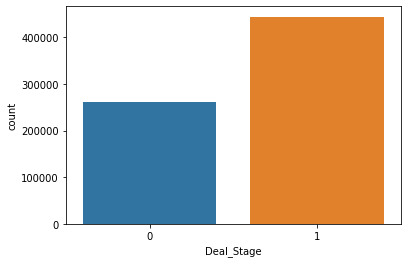

In [75]:
sns.countplot(newdf['Deal_Stage'])

## Text Cleaning and EDA

In [32]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import sqlite3
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [35]:
from bs4 import BeautifulSoup
from tqdm import tqdm
import re

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
len(stop)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SIDDHARTH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


179

In [37]:
import plotly.offline as pyoff
import plotly.graph_objs as go
from nltk.util import ngrams
import re
import unicodedata
import nltk

In [34]:
def cleaner(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can't", 'can not', phrase)
  
  # general
    phrase = re.sub(r"n\'t"," not", phrase)
    phrase = re.sub(r"\'re'"," are", phrase)
    phrase = re.sub(r"\'s"," is", phrase)
    phrase = re.sub(r"\'ll"," will", phrase)
    phrase = re.sub(r"\'d"," would", phrase)
    phrase = re.sub(r"\'t"," not", phrase)
    phrase = re.sub(r"\'ve"," have", phrase)
    phrase = re.sub(r"\'m"," am", phrase)
    
    return phrase

In [36]:
cleaned_title = []

for sentance in tqdm(newdf['Extracted Interaction Text'].values):
    sentance = str(sentance)
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = cleaner(sentance)
    sentance = re.sub(r'[?|!|\'|"|#|+]', r'', sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop)
    cleaned_title.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 704096/704096 [04:22<00:00, 2686.11it/s]


In [46]:
newdf['Extracted Interaction Text'] = cleaned_title

In [41]:
def basic_clean(text):
    
    """
    A simple function to clean up the data. All the words that
    are not designated as a stop word is then lemmatized after
    encoding and basic regex parsing are performed.
    """
    wnl = nltk.stem.WordNetLemmatizer()
    text = (unicodedata.normalize('NFKD', text)
        .encode('ascii', 'ignore')
        .decode('utf-8', 'ignore')
        .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words]

In [47]:
pos_words = basic_clean(''.join(str(newdf[newdf['Deal_Stage']==1]['Extracted Interaction Text'].tolist())))

In [100]:
trigram_pos=(pd.Series(nltk.ngrams(pos_words, 3)).value_counts())[:30]

trigram_pos=pd.DataFrame(trigram_pos)

In [101]:
trigram_pos['idx']=trigram_pos.index
trigram_pos['idx'] = trigram_pos.apply(lambda x: '('+x['idx'][0]+', '+x['idx'][1]+', ' + x['idx'][2]+')',axis=1)

In [103]:
plot_data = [
    go.Bar(
        x=trigram_pos['idx'],
        y=trigram_pos[0],
        marker = dict(
            color = 'Blue'
        )
    )
]
plot_layout = go.Layout(
        title='Top 30 tri-grams from Positive deals',
        yaxis_title='Count',
        xaxis_title='tri-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [51]:
neg_words = basic_clean(''.join(str(newdf[newdf['Deal_Stage']==0]['Extracted Interaction Text'].tolist())))

In [104]:
trigram_neg=(pd.Series(nltk.ngrams(neg_words, 3)).value_counts())[:30]

trigram_neg=pd.DataFrame(trigram_neg)

In [105]:
trigram_neg['idx']=trigram_neg.index

trigram_neg['idx'] = trigram_neg.apply(lambda x: '('+x['idx'][0]+', '+x['idx'][1]+', ' + x['idx'][2]+')',axis=1)

In [106]:
plot_data = [
    go.Bar(
        x=trigram_neg['idx'],
        y=trigram_neg[0],
        #name='True',
        #x_axis="OTI",
        #y_axis="time",
        marker = dict(
            color = 'Red'
        )
    )
]
plot_layout = go.Layout(
        title='Top 30 tri-grams from Negative Deals',
        yaxis_title='Count',
        xaxis_title='tri-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## Model Building

In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import classification_report
from prettytable import PrettyTable

In [165]:
newdf = newdf.sample(frac=1).reset_index(drop=True)

In [166]:
newdf.head()

,Deal_Stage,Close_Value,DateDiff,Extracted Interaction Text,Ordered_Agent,Ordered_Product
0,1,4639,635,letter response request weekly progress report...,12,3
1,0,588,725,sorry unable help individual tax return past y...,17,5
2,0,1026,401,gives immense pleasure write regard offer mark...,11,5
3,1,5068,29,iop corporation commence reduction work force ...,9,3
4,0,492,563,want compliment one excellent employees julie ...,27,5


In [167]:
X = newdf['Extracted Interaction Text']
y = newdf['Deal_Stage']

In [168]:
from sklearn.model_selection import train_test_split
X_Train, X_test, y_Train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [170]:
X_train, X_cross, y_train, y_cross = train_test_split(X_Train, y_Train, test_size=0.1, random_state=42, shuffle=True)

## Using TFI-DF Vectorizer

In [171]:
tf_idf=TfidfVectorizer(min_df=5,use_idf=True,ngram_range=(2,3))
tf_idf.fit(X_train)
Train_TFIDF = tf_idf.transform(X_train)
CrossVal_TFIDF = tf_idf.transform(X_cross)
Test_TFIDF= tf_idf.transform(X_test)

In [186]:
from sklearn.naive_bayes import MultinomialNB
alpha_set=[0.0001,0.001,0.01,0.1,1,10,100,1000]

Train_AUC_TFIDF = []
CrossVal_AUC_TFIDF = []


for i in alpha_set:
    naive_b=MultinomialNB(alpha=i)
    naive_b.fit(Train_TFIDF, y_train)
    Train_y_pred =  naive_b.predict_proba(Train_TFIDF)[:,1]
    Train_AUC_TFIDF.append(roc_auc_score(y_train,Train_y_pred))
    CrossVal_y_pred =  naive_b.predict_proba(CrossVal_TFIDF)[:,1]
    CrossVal_AUC_TFIDF.append(roc_auc_score(y_cross,CrossVal_y_pred))

In [187]:
Alpha_set=[]
for i in range(len(alpha_set)):
    Alpha_set.append(np.math.log(alpha_set[i]))

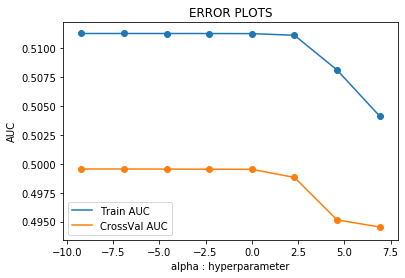

In [188]:
plt.plot(Alpha_set, Train_AUC_TFIDF, label='Train AUC')
plt.scatter(Alpha_set, Train_AUC_TFIDF)
plt.plot(Alpha_set, CrossVal_AUC_TFIDF, label='CrossVal AUC')
plt.scatter(Alpha_set, CrossVal_AUC_TFIDF)
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [189]:
optimal_alpha=alpha_set[CrossVal_AUC_TFIDF.index(max(CrossVal_AUC_TFIDF))]
print(optimal_alpha)

0.0001


In [190]:
Classifier2 = MultinomialNB(alpha=optimal_alpha)
Classifier2.fit(Train_TFIDF, y_train)

MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True)

In [191]:
y_pred = Classifier2.predict(Test_TFIDF)

In [192]:
print(confusion_matrix(y_test, y_pred))
print('Accuracy of our model is: ', accuracy_score(y_test, y_pred))

[[  250 51874]
 [  453 88243]]
Accuracy of our model is:  0.6284121573640108


In [193]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.36      0.00      0.01     52124
           1       0.63      0.99      0.77     88696

    accuracy                           0.63    140820
   macro avg       0.49      0.50      0.39    140820
weighted avg       0.53      0.63      0.49    140820



## Classification using Text and numeric Features

In [180]:
Train_TFIDF_mix = (hstack((Train_TFIDF,np.array(Train_agent)[:,None], np.array(Train_pdt)[:,None], np.array(Train_diff)[:,None], np.array(Train_val)[:,None]))).tocsr()

Cross_TFIDF_mix = (hstack((CrossVal_TFIDF,np.array(cross_agent)[:,None], np.array(cross_pdt)[:,None], np.array(cross_diff)[:,None], np.array(cross_val)[:,None]))).tocsr()

Test_TFIDF_mix = (hstack((Test_TFIDF,np.array(test_agent)[:,None], np.array(test_pdt)[:,None], np.array(test_diff)[:,None], np.array(test_val)[:,None]))).tocsr()

In [181]:
alpha_set=[0.00001,0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0]
Train_AUC_TFIDF = []
CrossVal_AUC_TFIDF = []
for i in alpha_set:
  naive_b=MultinomialNB(alpha=i)
  naive_b.fit(Train_TFIDF_mix, y_train)
  Train_y_pred =  naive_b.predict_proba(Train_TFIDF_mix)[:,1]
  Train_AUC_TFIDF.append(roc_auc_score(y_train,Train_y_pred))
  CrossVal_y_pred =  naive_b.predict_proba(Cross_TFIDF_mix)[:,1]
  CrossVal_AUC_TFIDF.append(roc_auc_score(y_cross,CrossVal_y_pred))

In [182]:
Alpha_set=[]
for i in range(len(alpha_set)):
  Alpha_set.append(math.log(alpha_set[i]))

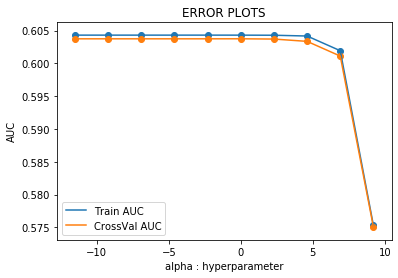

In [183]:
plt.plot(Alpha_set, Train_AUC_TFIDF, label='Train AUC')
plt.scatter(Alpha_set, Train_AUC_TFIDF)
plt.plot(Alpha_set, CrossVal_AUC_TFIDF, label='CrossVal AUC')
plt.scatter(Alpha_set, CrossVal_AUC_TFIDF)
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [159]:
optimal_alpha=alpha_set[CrossVal_AUC_TFIDF.index(max(CrossVal_AUC_TFIDF))]
print(optimal_alpha)

1.0


In [160]:
Classifier=MultinomialNB(alpha=optimal_alpha)
Classifier.fit(Train_TFIDF_mix, y_train)
Train_FPR, Train_TPR, Thresholds = roc_curve(y_train, Classifier.predict_proba(Train_TFIDF_mix)[:,1])
Test_FPR, Test_TPR, Thresholds = roc_curve(y_test, Classifier.predict_proba(Test_TFIDF_mix)[:,1])

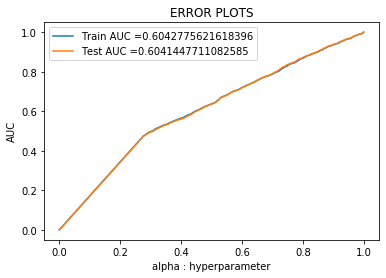

In [161]:
plt.plot(Train_FPR, Train_TPR, label="Train AUC ="+str(auc(Train_FPR, Train_TPR)))
plt.plot(Test_FPR, Test_TPR, label="Test AUC ="+str(auc(Test_FPR, Test_TPR)))
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [162]:
y_pred = Classifier.predict(Test_TFIDF_mix)

In [163]:
print(confusion_matrix(y_test, y_pred))
print('Accuracy of our model is: ', accuracy_score(y_test, y_pred))

[[34049 18075]
 [41687 47009]]
Accuracy of our model is:  0.5756142593381622


In [164]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.65      0.53     52124
           1       0.72      0.53      0.61     88696

    accuracy                           0.58    140820
   macro avg       0.59      0.59      0.57    140820
weighted avg       0.62      0.58      0.58    140820



## Using Bag OF Words

In [76]:
from sklearn.feature_extraction.text import CountVectorizer

In [89]:
count = CountVectorizer()
count.fit(X_train)
Train_BOW = count.transform(X_train)
CrossVal_BOW = count.transform(X_cross)
Test_BOW= count.transform(X_test)

In [91]:
alpha_set=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
Train_AUC_BOW = []
CrossVal_AUC_BOW = []
for i in alpha_set:
  naive_b=MultinomialNB(alpha=i)
  naive_b.fit(Train_BOW, y_train)
  Train_y_pred =  naive_b.predict_proba(Train_BOW)[:,1]
  Train_AUC_BOW.append(roc_auc_score(y_train,Train_y_pred))
  CrossVal_y_pred =  naive_b.predict_proba(CrossVal_BOW)[:,1]
  CrossVal_AUC_BOW.append(roc_auc_score(y_cross,CrossVal_y_pred))

In [92]:
from numpy import math
Alpha_set=[]
for i in range(len(alpha_set)):
  Alpha_set.append(math.log(alpha_set[i]))

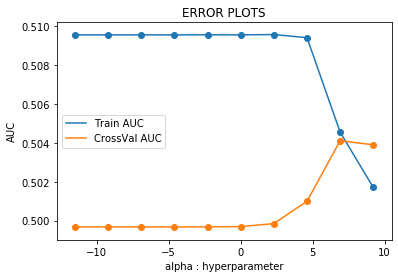

In [93]:
plt.plot(Alpha_set, Train_AUC_BOW, label='Train AUC')
plt.scatter(Alpha_set, Train_AUC_BOW)
plt.plot(Alpha_set, CrossVal_AUC_BOW, label='CrossVal AUC')
plt.scatter(Alpha_set, CrossVal_AUC_BOW)
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [94]:
optimal_alpha=alpha_set[CrossVal_AUC_BOW.index(max(CrossVal_AUC_BOW))]
print(optimal_alpha)

1000


In [95]:
Classifier=MultinomialNB(alpha=optimal_alpha)
Classifier.fit(Train_BOW, y_train)
Train_FPR, Train_TPR, Thresholds = roc_curve(y_train, Classifier.predict_proba(Train_BOW)[:,1])
Test_FPR, Test_TPR, Thresholds = roc_curve(y_test, Classifier.predict_proba(Test_BOW)[:,1])

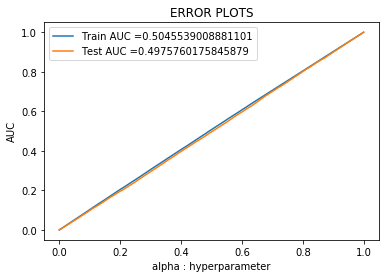

In [96]:
plt.plot(Train_FPR, Train_TPR, label="Train AUC ="+str(auc(Train_FPR, Train_TPR)))
plt.plot(Test_FPR, Test_TPR, label="Test AUC ="+str(auc(Test_FPR, Test_TPR)))
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [98]:
y_pred = Classifier.predict(Test_BOW)

In [99]:
print(confusion_matrix(y_test, y_pred))
print('Accuracy of our model is: ', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

[[ 2899 49225]
 [ 4900 83796]]
Accuracy of our model is:  0.6156440846470672
              precision    recall  f1-score   support

           0       0.37      0.06      0.10     52124
           1       0.63      0.94      0.76     88696

    accuracy                           0.62    140820
   macro avg       0.50      0.50      0.43    140820
weighted avg       0.53      0.62      0.51    140820



In [97]:
neg_class_prob_sorted = abs(Classifier.feature_log_prob_[0, :]).argsort()
pos_class_prob_sorted = abs(Classifier.feature_log_prob_[1, :]).argsort()
print("Top 10 negative class words")
print(np.take(count.get_feature_names(), neg_class_prob_sorted[:10]))
print("\nTop 10 positive class words")
print(np.take(count.get_feature_names(), pos_class_prob_sorted[0:10]))

Top 10 negative class words
['company' 'proposal' 'work' 'business' 'time' 'inform' 'thank' 'position'
 'us' 'forward']

Top 10 positive class words
['company' 'proposal' 'work' 'business' 'time' 'inform' 'position' 'thank'
 'us' 'forward']


In [107]:
from scipy.sparse import hstack

In [108]:
newdf.columns

Index(['Deal_Stage', 'Close_Value', 'DateDiff', 'Extracted Interaction Text',
       'Ordered_Agent', 'Ordered_Product'],
      dtype='object')

## Classification using text and numeric features

In [132]:
newdf = newdf.sample(frac=1).reset_index(drop=True)
newdf.head()

,Deal_Stage,Close_Value,DateDiff,Extracted Interaction Text,Ordered_Agent,Ordered_Product
0,1,577,0,writing behalf abc company let know accepted a...,20,4
1,1,622,88,however number highly qualified candidates app...,7,4
2,0,560,196,convinced proposal submitted,0,5
3,1,5455,257,sorry inform finalized deal company offering f...,23,5
4,1,594,199,good make acquaintance last week optimistic ac...,8,4


In [133]:
X = newdf.drop('Deal_Stage', axis=1)
y = newdf['Deal_Stage']

In [135]:
X_Train, X_test, y_Train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

X_train, X_cross, y_train, y_cross = train_test_split(X_Train, y_Train, test_size=0.1, random_state=42, shuffle=True)

In [136]:
Train_agent=[]
for i in X_train['Ordered_Agent']:
    Train_agent.append(i)
Train_pdt=[]
for i in X_train['Ordered_Product']:
    Train_pdt.append(i)
Train_diff=[]
for i in X_train['DateDiff']:
    Train_diff.append(i)
Train_val=[]
for i in X_train['Close_Value']:
    Train_val.append(i)

In [137]:
cross_agent=[]
for i in X_cross['Ordered_Agent']:
    cross_agent.append(i)
cross_pdt=[]
for i in X_cross['Ordered_Product']:
    cross_pdt.append(i)
cross_diff=[]
for i in X_cross['DateDiff']:
    cross_diff.append(i)
cross_val=[]
for i in X_cross['Close_Value']:
    cross_val.append(i)

In [138]:
test_agent=[]
for i in X_test['Ordered_Agent']:
    test_agent.append(i)
test_pdt=[]
for i in X_test['Ordered_Product']:
    test_pdt.append(i)
test_diff=[]
for i in X_test['DateDiff']:
    test_diff.append(i)
test_val=[]
for i in X_test['Close_Value']:
    test_val.append(i)

In [139]:
Train_BOW_mix = (hstack((Train_BOW,np.array(Train_agent)[:,None], np.array(Train_pdt)[:,None], np.array(Train_diff)[:,None], np.array(Train_val)[:,None]))).tocsr()

In [140]:
Cross_BOW_mix = (hstack((CrossVal_BOW,np.array(cross_agent)[:,None], np.array(cross_pdt)[:,None], np.array(cross_diff)[:,None], np.array(cross_val)[:,None]))).tocsr()

In [141]:
Test_BOW_mix = (hstack((Test_BOW,np.array(test_agent)[:,None], np.array(test_pdt)[:,None], np.array(test_diff)[:,None], np.array(test_val)[:,None]))).tocsr()

In [122]:
#Hyperparameter Tuning

In [142]:
alpha_set=[0.00001,0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0]
Train_AUC_BOW = []
CrossVal_AUC_BOW = []
for i in alpha_set:
  naive_b=MultinomialNB(alpha=i)
  naive_b.fit(Train_BOW_mix, y_train)
  Train_y_pred =  naive_b.predict_proba(Train_BOW_mix)[:,1]
  Train_AUC_BOW.append(roc_auc_score(y_train,Train_y_pred))
  CrossVal_y_pred =  naive_b.predict_proba(Cross_BOW_mix)[:,1]
  CrossVal_AUC_BOW.append(roc_auc_score(y_cross,CrossVal_y_pred))

In [143]:
Alpha_set=[]
for i in range(len(alpha_set)):
  Alpha_set.append(math.log(alpha_set[i]))

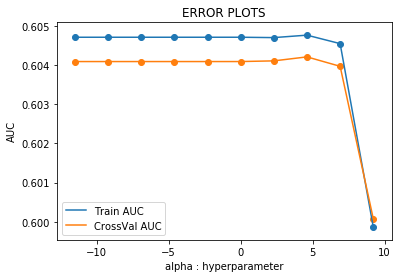

In [144]:
plt.plot(Alpha_set, Train_AUC_BOW, label='Train AUC')
plt.scatter(Alpha_set, Train_AUC_BOW)
plt.plot(Alpha_set, CrossVal_AUC_BOW, label='CrossVal AUC')
plt.scatter(Alpha_set, CrossVal_AUC_BOW)
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [145]:
optimal_alpha=alpha_set[CrossVal_AUC_BOW.index(max(CrossVal_AUC_BOW))]
print(optimal_alpha)

100.0


In [146]:
Classifier=MultinomialNB(alpha=optimal_alpha)
Classifier.fit(Train_BOW_mix, y_train)
Train_FPR, Train_TPR, Thresholds = roc_curve(y_train, Classifier.predict_proba(Train_BOW_mix)[:,1])
Test_FPR, Test_TPR, Thresholds = roc_curve(y_test, Classifier.predict_proba(Test_BOW_mix)[:,1])

C:\Users\SIDDHARTH\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



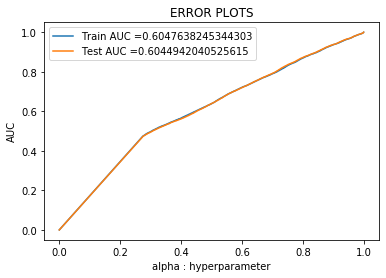

In [147]:
plt.plot(Train_FPR, Train_TPR, label="Train AUC ="+str(auc(Train_FPR, Train_TPR)))
plt.plot(Test_FPR, Test_TPR, label="Test AUC ="+str(auc(Test_FPR, Test_TPR)))
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [148]:
y_pred = Classifier.predict(Test_BOW_mix)

In [149]:
print(confusion_matrix(y_test, y_pred))
print('Accuracy of our model is: ', accuracy_score(y_test, y_pred))

[[34254 17870]
 [42000 46696]]
Accuracy of our model is:  0.5748473228234626


In [150]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.66      0.53     52124
           1       0.72      0.53      0.61     88696

    accuracy                           0.57    140820
   macro avg       0.59      0.59      0.57    140820
weighted avg       0.62      0.57      0.58    140820



In [154]:
neg_class_prob_sorted = abs(Classifier.feature_log_prob_[0, :1315]).argsort()
pos_class_prob_sorted = abs(Classifier.feature_log_prob_[1, :1315]).argsort()
print("Top 10 negative class words")
print(np.take(count.get_feature_names(), neg_class_prob_sorted[:10]))
print("\nTop 10 positive class words")
print(np.take(count.get_feature_names(), pos_class_prob_sorted[0:10]))

Top 10 negative class words
['company' 'proposal' 'work' 'business' 'time' 'inform' 'thank' 'position'
 'us' 'forward']

Top 10 positive class words
['company' 'proposal' 'work' 'business' 'time' 'inform' 'position' 'thank'
 'us' 'forward']


In [194]:
newdf.to_csv('clean_sales.csv')

In [195]:
x = PrettyTable()

x.field_names = ["VECTORIZER", "NUMERIC INCLUDED", "HYPER PARAMETER", "AREA UNDER CURVE"]

x.add_row(["BOW","YES",1,0.60451])
x.add_row(["BOW","NO",1000, 0.49576])
x.add_row(["TFIDF","YES",1,0.60421])
x.add_row(["TFIDF","NO",100,0.52100])
print(x)

+------------+------------------+-----------------+------------------+
| VECTORIZER | NUMERIC INCLUDED | HYPER PARAMETER | AREA UNDER CURVE |
+------------+------------------+-----------------+------------------+
|    BOW     |       YES        |        1        |     0.60451      |
|    BOW     |        NO        |       1000      |     0.49576      |
|   TFIDF    |       YES        |        1        |     0.60421      |
|   TFIDF    |        NO        |       100       |      0.521       |
+------------+------------------+-----------------+------------------+
